<a href="https://colab.research.google.com/github/rodrigoviannini/Machine-Learning/blob/main/Aula_17_feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aula 17 - feature selection

Na aula de hoje, vamos explorar os seguintes tópicos em Python:

- 1) Introdução
- 2) Lasso
- 3) Feature importance com árvores
- 4) RFE


In [ ]:
import numpy  as np
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

def metricas_classificacao(estimator, X_train, X_test, y_train, y_test):
    
    # ============================================

    print("\nMétricas de avaliação de treino:")

    y_pred_train = estimator.predict(X_train)

    print(confusion_matrix(y_train, y_pred_train))

    ConfusionMatrixDisplay.from_predictions(y_train, y_pred_train)
    plt.show()

    print(classification_report(y_train, y_pred_train))

    # ============================================

    print("\nMétricas de avaliação de teste:")

    y_pred_test = estimator.predict(X_test)

    print(confusion_matrix(y_test, y_pred_test))

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_test)
    plt.show()

    print(classification_report(y_test, y_pred_test))

____
____
_____

## 1) Introdução

O processo de **feature selection** (**seleção de atributos**) consiste na escolha, com base em alguns critérios, de um **subconjunto do conjunto original** de features de um dado problema, que proporcionem um modelo com performance comparável ao modelo treinado com todas as features. 

<img src=https://miro.medium.com/max/694/0*D_jQ5yBsvCZjEYIW width=400>

O resultado do processo de feature selection é uma **redução na dimensionalidade** do espaço de features do problema (mas aqui, diferente do PCA, trabalhamos no espaço de features originais!)

Assim, o processo remove features redundantes ou irrelevantes. 

Dentre as vantagens do procedimento, podemos destacar:

- Maior eficiência no treinamento (afinal, reduzimos a quantidade de informação a ser processada);
- Eliminação de redundâncias (como multicolinearidade, por exemplo, que pode ser problemática para alguns estimadores);
- Um modelo mais enxuto, com menos features, é, em geral, mais facilmente interpretável;
- Ao reduzirmos o número de features, a complexidade da hipótese é reduzida, o que pode favorecer a generalização;

O princípio da [navalha de Occam](https://pt.wikipedia.org/wiki/Navalha_de_Ockham) é relevante no contexto de feature selection em projetos de machine learning. Sugiro [este post](https://machinelearningmastery.com/ensemble-learning-and-occams-razor/#:~:text=Occam's%20razor%20suggests%20that%20in,narrow%20and%20not%20generalize%20well.) para uma discussão deste princípio como uma heurística para a construção de modelos. Para uma discussão mais profunda, sugiro [este paper](https://www.aaai.org/Papers/KDD/1998/KDD98-006.pdf).



Na aula de hoje, veremos alguns procedimentos de feature selection. Vamos começar!

______________

## 2) LASSO

Já conhecemos um método capaz de realizar feature selection: a **regularização L1 (LASSO)**.

Diferente da regularização L2, quando utilizamos regularização L1 é possível zerar alguns dos parâmetros do modelo:

<img src=https://ugc.futurelearn.com/uploads/assets/2b/fe/2bfe399e-503e-4eae-9138-a3d7da738713.png width=800>

Embora ambas as modalidades de regularização tenha, sido introduzidas com o intuito de simplificar o espaço de hipóteses, o LASSO faz isso de maneira explítica, efetivamente possibilitando a realização de feature selection!

No entanto, há um problema: são poucos os métodos que têm o LASSO incorporado (ex.: regressão linear, logística, XGBoost).

Assim, se quisermos realizar feature selection utilizando outros estimadores, precisamos de técnicas mais genéricas, que é o que veremos a seguir.

Para utilizarmos o L1, uma abordagem possível é:

- **treinar inicialmente um modelo com LASSO**; 
- identificar quais features **ainda estão presentes no modelo** (isto é, com `coef_` não nulo);
- utilizar estas features apenas para treinar o estimador desejado.

Embora esta seja uma possibilidade, veremos, a seguir, que há técnicas que possibilitam este procedimento, de maneira mais geral!

______________

## 3) Feature importance com árvores

Além de estimadores poderosos, podemos utilizar árvores para fazer feature selection! 

Há duas formas comuns de utilizarmos árvores para a determinação da importância de features. Vamos conhecer cada uma na prática, utilizando um dataset familiar!

In [ ]:
df_bc = pd.read_csv("../datasets/breast_cancer.csv")

X = df_bc.drop(columns=["id", "diagnosis"])
y = df_bc["diagnosis"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, stratify=y)

### `.feature_importances_`, com base em decréscimo de impureza (MDI)

Neste caso, o score de importância de cada uma das features é calculado com base na **média e desvio padrão da diminuição de impureza que cada feature proporciona na árvore (ou em cada árvore, no caso de ensembles)**.

O método é conhecido como **mean decrease in impurity** (MDI).

Este método é rápido, no entanto, o valor é fortemente enviesado para features que têm alta cardinalidade (features numéricas, ou features categóricas com muitos níveis).

Neste caso, é melhor utilizar o método de permutation feature importance. Para uma comparação detalhada entre os dois métodos, [veja esta página](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py).

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier().fit(X_train, y_train)

In [ ]:
dt.feature_names_in_

array(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se',
       'smoothness_se', 'compactness_se', 'concavity_se',
       'concave points_se', 'symmetry_se', 'fractal_dimension_se',
       'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst',
       'smoothness_worst', 'compactness_worst', 'concavity_worst',
       'concave points_worst', 'symmetry_worst',
       'fractal_dimension_worst'], dtype=object)

In [ ]:
dt.feature_importances_

array([0.        , 0.03787113, 0.        , 0.02245225, 0.01126935,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.02310217, 0.020234  , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01002327, 0.73442676, 0.01560649, 0.04083276,
       0.        , 0.00306561, 0.0811162 , 0.        , 0.        ])

In [ ]:
feature_importances_dt = pd.Series(dt.feature_importances_, index=dt.feature_names_in_).sort_values(ascending=False)

In [ ]:
feature_importances_dt

perimeter_worst            0.734427
concave points_worst       0.081116
smoothness_worst           0.040833
texture_mean               0.037871
perimeter_se               0.023102
area_mean                  0.022452
area_se                    0.020234
area_worst                 0.015606
smoothness_mean            0.011269
texture_worst              0.010023
concavity_worst            0.003066
radius_worst               0.000000
radius_mean                0.000000
symmetry_se                0.000000
compactness_worst          0.000000
symmetry_worst             0.000000
fractal_dimension_se       0.000000
compactness_se             0.000000
concave points_se          0.000000
concavity_se               0.000000
smoothness_se              0.000000
texture_se                 0.000000
radius_se                  0.000000
fractal_dimension_mean     0.000000
symmetry_mean              0.000000
concave points_mean        0.000000
concavity_mean             0.000000
compactness_mean           0

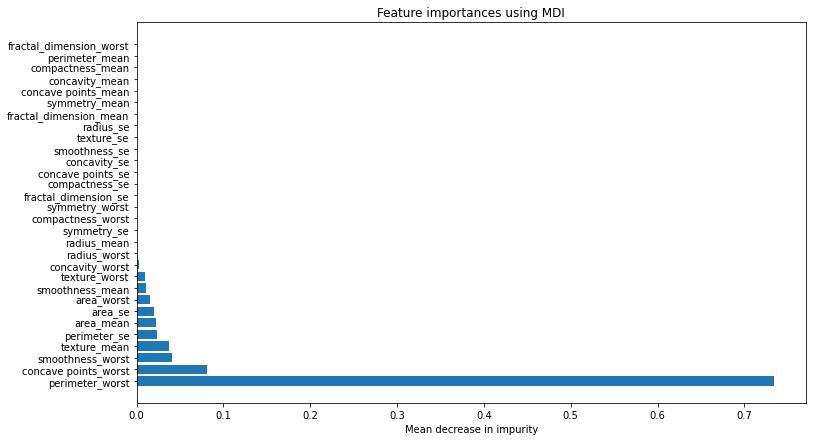

In [ ]:
plt.figure(figsize=(12, 7))

plt.title("Feature importances using MDI")

plt.barh(feature_importances_dt.index, feature_importances_dt.values)

plt.xlabel("Mean decrease in impurity")

plt.show()

In [ ]:
# n pratica, essas são as features que usamos pra treinar o modelo "pra valer"

top10_dt = feature_importances_dt[:10].index

Os resultados não são tão legais com uma única árvore. O método fica mais robusto se utilizarmos um ensemble:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000,
                            random_state=42).fit(X_train, y_train)

In [ ]:
np.mean([tree.feature_importances_ for tree in rf.estimators_], axis=0)

array([0.0534713 , 0.01431477, 0.05209523, 0.04698601, 0.00664372,
       0.01508028, 0.04830772, 0.08456224, 0.00444487, 0.00348198,
       0.01316529, 0.0044573 , 0.01124926, 0.03270024, 0.00390753,
       0.00511705, 0.00640746, 0.00444686, 0.00360683, 0.0064335 ,
       0.11128865, 0.01732051, 0.12808803, 0.12573206, 0.01283202,
       0.01498351, 0.03222754, 0.11578857, 0.01458551, 0.00627416])

In [ ]:
rf.feature_importances_

array([0.0534713 , 0.01431477, 0.05209523, 0.04698601, 0.00664372,
       0.01508028, 0.04830772, 0.08456224, 0.00444487, 0.00348198,
       0.01316529, 0.0044573 , 0.01124926, 0.03270024, 0.00390753,
       0.00511705, 0.00640746, 0.00444686, 0.00360683, 0.0064335 ,
       0.11128865, 0.01732051, 0.12808803, 0.12573206, 0.01283202,
       0.01498351, 0.03222754, 0.11578857, 0.01458551, 0.00627416])

In [ ]:
std_fis_rf = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

In [ ]:
std_fis_rf

array([0.15868514, 0.02107007, 0.15881249, 0.14552804, 0.01250426,
       0.05928361, 0.14086902, 0.19821626, 0.0099455 , 0.00838902,
       0.05262851, 0.00918089, 0.04676482, 0.10641154, 0.00825516,
       0.01245206, 0.02069869, 0.01626946, 0.00773664, 0.01214363,
       0.23530556, 0.02507813, 0.25550461, 0.24791682, 0.02286022,
       0.04094111, 0.091316  , 0.22574563, 0.02865232, 0.01400309])

In [ ]:
feature_importances_rf = pd.Series(rf.feature_importances_, index=rf.feature_names_in_).sort_values(ascending=False)

feature_importances_rf

perimeter_worst            0.128088
area_worst                 0.125732
concave points_worst       0.115789
radius_worst               0.111289
concave points_mean        0.084562
radius_mean                0.053471
perimeter_mean             0.052095
concavity_mean             0.048308
area_mean                  0.046986
area_se                    0.032700
concavity_worst            0.032228
texture_worst              0.017321
compactness_mean           0.015080
compactness_worst          0.014984
symmetry_worst             0.014586
texture_mean               0.014315
radius_se                  0.013165
smoothness_worst           0.012832
perimeter_se               0.011249
smoothness_mean            0.006644
fractal_dimension_se       0.006434
concavity_se               0.006407
fractal_dimension_worst    0.006274
compactness_se             0.005117
texture_se                 0.004457
concave points_se          0.004447
symmetry_mean              0.004445
smoothness_se              0

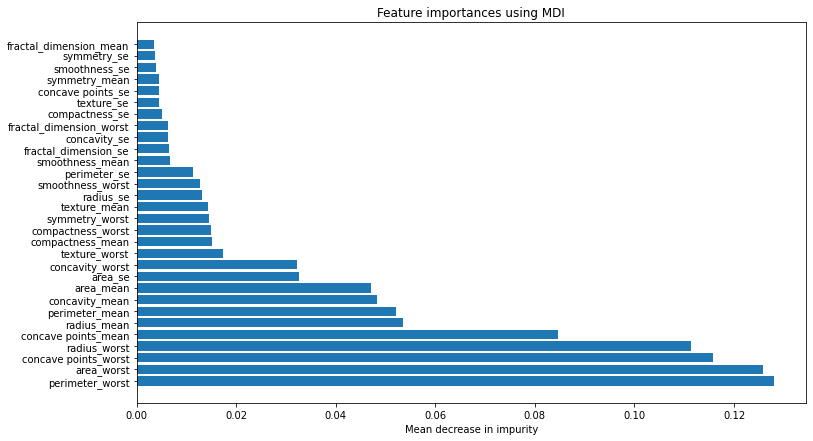

In [ ]:
plt.figure(figsize=(12, 7))

plt.title("Feature importances using MDI")

plt.barh(feature_importances_rf.index, feature_importances_rf.values)

plt.xlabel("Mean decrease in impurity")

plt.show()

Vamos dar uma olhada na variação...

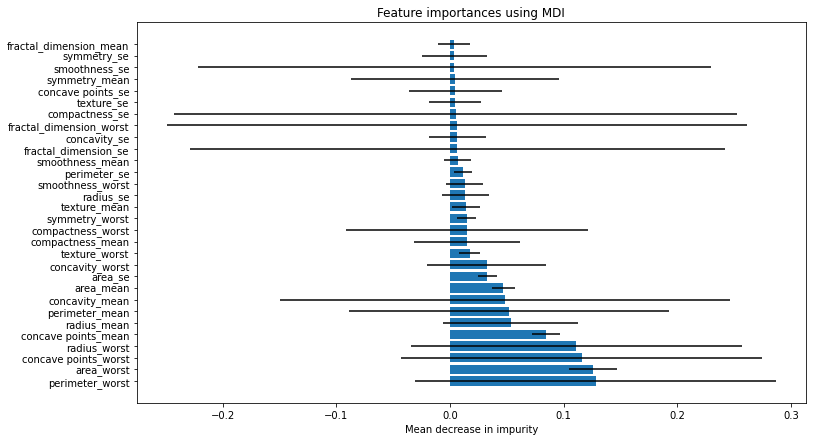

In [ ]:
plt.figure(figsize=(12, 7))

plt.title("Feature importances using MDI")

# aqui, mesmo plot, mas com as barras de erro (desvio padrão que calculamos acima)
plt.barh(feature_importances_rf.index, feature_importances_rf.values, xerr=std_fis_rf)

plt.xlabel("Mean decrease in impurity")

plt.show()

In [ ]:
top10_dt

Index(['perimeter_worst', 'concave points_worst', 'smoothness_worst',
       'texture_mean', 'perimeter_se', 'area_mean', 'area_se', 'area_worst',
       'smoothness_mean', 'texture_worst'],
      dtype='object')

In [ ]:
top10_rf_fi = feature_importances_rf[:10].index

top10_rf_fi

Index(['perimeter_worst', 'area_worst', 'concave points_worst', 'radius_worst',
       'concave points_mean', 'radius_mean', 'perimeter_mean',
       'concavity_mean', 'area_mean', 'area_se'],
      dtype='object')

In [ ]:
[x for x in top10_dt if x not in top10_rf_fi]

['smoothness_worst',
 'texture_mean',
 'perimeter_se',
 'smoothness_mean',
 'texture_worst']

In [ ]:
[x for x in top10_rf_fi if x not in top10_dt]

['radius_worst',
 'concave points_mean',
 'radius_mean',
 'perimeter_mean',
 'concavity_mean']

In [ ]:
[x for x in top10_rf_fi if x in top10_dt]

['perimeter_worst',
 'area_worst',
 'concave points_worst',
 'area_mean',
 'area_se']

A variação é enorme! O que pode ter acontecido?

Isso se deve justamente ao viés indesejado que é introduzido pelo MDI. Para corrigir isso, vamos introduzir um novo método!

### `permutation_importance()`, com base em permutação de features

Neste método, utilizamos a função `sklearn.inspection.permutation_importance()`, que vai criar permutações das features, mantendo um registro de um score, e como ele é afetado quando uma ou outra feature é eliminada.

Por realizar diversas permutações, este método é mais custoso, mas tem a vantagem de eliminar o viés que features de alta cardinalidade carregam com o método baseado em impureza.

Para maiores detalhes sobre o método, [clique aqui!](https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance)

> Observação: embora tenhamos ilustrado a importância de permutação com a árvore de decisão, na realidade este é um método que pode ser usado com qualquer estimador!

A função que vamos utilizar [está aqui!](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html)

In [ ]:
dt = DecisionTreeClassifier().fit(X_train, y_train)

In [ ]:
from sklearn.inspection import permutation_importance

result_perm = permutation_importance(dt, X_train, y_train, n_repeats=20, random_state=42, n_jobs=-1)

In [ ]:
result_perm.importances_mean

array([0.        , 0.03      , 0.        , 0.12      , 0.        ,
       0.00175824, 0.        , 0.        , 0.00615385, 0.00175824,
       0.        , 0.        , 0.00527473, 0.05241758, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01692308, 0.06340659, 0.02538462, 0.03956044,
       0.        , 0.01241758, 0.07428571, 0.        , 0.        ])

In [ ]:
result_perm.importances_std

array([0.        , 0.0052137 , 0.        , 0.01214572, 0.        ,
       0.00164468, 0.        , 0.        , 0.00246703, 0.00149062,
       0.        , 0.        , 0.00175824, 0.00645552, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00476979, 0.00981104, 0.00493772, 0.00666626,
       0.        , 0.00312946, 0.01130534, 0.        , 0.        ])

In [ ]:
data = {"importance": result_perm.importances_mean,
        "std" : result_perm.importances_std}

df_fi_perm = pd.DataFrame(data, index=dt.feature_names_in_).sort_values("importance", ascending=False)

df_fi_perm

,importance,std
area_mean,0.120000,0.012146
concave points_worst,0.074286,0.011305
perimeter_worst,0.063407,0.009811
area_se,0.052418,0.006456
smoothness_worst,0.039560,0.006666
texture_mean,0.030000,0.005214
area_worst,0.025385,0.004938
texture_worst,0.016923,0.004770
concavity_worst,0.012418,0.003129
symmetry_mean,0.006154,0.002467


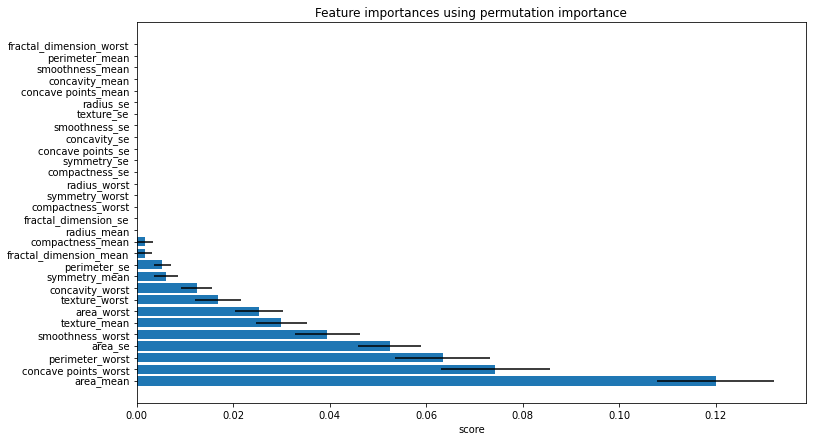

In [ ]:
plt.figure(figsize=(12, 7))

plt.title("Feature importances using permutation importance")

plt.barh(df_fi_perm.index, df_fi_perm["importance"], xerr=df_fi_perm["std"])

plt.xlabel("score")

plt.show()

In [ ]:
top10_dt

Index(['perimeter_worst', 'concave points_worst', 'smoothness_worst',
       'texture_mean', 'perimeter_se', 'area_mean', 'area_se', 'area_worst',
       'smoothness_mean', 'texture_worst'],
      dtype='object')

In [ ]:
top10_rf_fi

Index(['perimeter_worst', 'area_worst', 'concave points_worst', 'radius_worst',
       'concave points_mean', 'radius_mean', 'perimeter_mean',
       'concavity_mean', 'area_mean', 'area_se'],
      dtype='object')

In [ ]:
top10_perm = df_fi_perm[:10].index

In [ ]:
[x for x in top10_perm if x not in top10_dt]

['concavity_worst', 'symmetry_mean']

In [ ]:
[x for x in top10_perm if x not in top10_rf_fi]

['smoothness_worst',
 'texture_mean',
 'texture_worst',
 'concavity_worst',
 'symmetry_mean']

A partir daqui, o próximo passo seria treinar um modelo normalmente (pipeline, gridsearch, etc.), mas apenas com essas features selecionadas (idealmente, uma combinação dessas heurísticas).

______________

## 4) RFE

Conheceremos agora o método **Recursive Feature Elimination** (RFE).

O RFE é um método que se utiliza de um estimador capaz de atribuir um score de **importância** a cada uma das features.

> Por exemplo, podemos olhar para os coeficientes de um modelo linear (`coef_`), ou então, para os scores de importância de features (`feature_importances_`).

O método então considera recursivamente **subconjuntos cada vez menores de features**, da seguinte maneira:

- O estimador é treinado inicialmente com todas as features;
- A importância de cada uma das features é calculada;
- As features menos importantes são retiradas do conjunto de features;
- O processo recomeça, até que o número  desejado de features seja alcançado.

Sendo assim, temos dois hiperparâmetros importantes na classe [RFE](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html):

- `estimator`: o estimador que irá disponibilizar os scores de importância de features;
- `n_features_to_select`: a quantidade de features que o subconjunto final terá.

Na prática, podemos utilizar um gridsearch para otimizar estes dois hiperparâmetros, ou então utilizar a classe [RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html), que determina o melhor númeo de features automaticamente.

Vamos ver o método na prática!

In [ ]:
from sklearn.feature_selection import RFE

rfe = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=10).fit(X_train, y_train)

In [ ]:
X_train.columns

Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [ ]:
rfe.support_

array([False,  True, False,  True, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False,  True,  True,  True,  True,  True,  True,
        True, False, False])

In [ ]:
top10_rfe = X_train.columns[rfe.support_]

In [ ]:
top10_rfe

Index(['texture_mean', 'area_mean', 'area_se', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst'],
      dtype='object')

In [ ]:
top10_dt

Index(['perimeter_worst', 'concave points_worst', 'smoothness_worst',
       'texture_mean', 'perimeter_se', 'area_mean', 'area_se', 'area_worst',
       'smoothness_mean', 'texture_worst'],
      dtype='object')

In [ ]:
[features for features in top10_rfe if features not in top10_dt]

['compactness_worst', 'concavity_worst']

In [ ]:
[features for features in top10_dt if features not in top10_rfe]

['perimeter_se', 'smoothness_mean']

In [ ]:
[features for features in top10_dt if features in top10_rfe]

['perimeter_worst',
 'concave points_worst',
 'smoothness_worst',
 'texture_mean',
 'area_mean',
 'area_se',
 'area_worst',
 'texture_worst']

Vamos ver como funciona o [RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html):

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

splitter = StratifiedKFold(n_splits=5)

rfecv = RFECV(estimator=DecisionTreeClassifier(),
              scoring="f1_weighted",
              cv=splitter).fit(X_train, y_train)

In [ ]:
pd.DataFrame(rfecv.cv_results_)

,mean_test_score,std_test_score,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score
0,0.892527,0.023074,0.911514,0.890699,0.880041,0.922837,0.857546
1,0.916098,0.042499,0.966930,0.956279,0.865048,0.922837,0.869397
2,0.944880,0.018448,0.966930,0.966930,0.933635,0.934066,0.922837
3,0.945044,0.023132,0.956044,0.967126,0.922837,0.967126,0.912088
4,0.945109,0.037365,0.967126,0.956279,0.933635,0.989042,0.879462
5,0.929774,0.035598,0.956044,0.967126,0.910831,0.945473,0.869397
6,0.931983,0.037454,0.966930,0.945473,0.910831,0.967284,0.869397
7,0.936331,0.040533,0.978022,0.967126,0.910831,0.956279,0.869397
8,0.938374,0.037043,0.978022,0.966930,0.910831,0.956044,0.880041
9,0.922889,0.032620,0.955757,0.956044,0.888538,0.934066,0.880041


In [ ]:
rfecv.n_features_

5

In [ ]:
rfecv.support_

array([False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True, False, False,
        True, False, False])

In [ ]:
X_train.columns[rfecv.support_]

Index(['texture_mean', 'perimeter_worst', 'area_worst', 'smoothness_worst',
       'concave points_worst'],
      dtype='object')

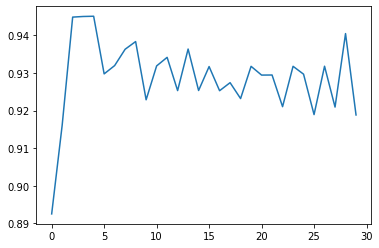

In [ ]:
plt.plot(range(len(scores)), scores);

Na prática, podemos incluir o RFE como um passo da Pipeline, e otimizar seus parâmetros com o grid search!

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

pipe = Pipeline([("rfe", RFE(estimator=DecisionTreeClassifier(random_state=42))),
                 ("ab", AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                                                 criterion="gini",
                                                                                 max_features="sqrt",
                                                                                 random_state=42),
                                           random_state=42))])

param_grid_ab = {"rfe__n_features_to_select" : range(1, X_train.shape[1]+1),
                 "ab__n_estimators" : [100, 150]}

splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_ab = GridSearchCV(pipe, param_grid_ab, scoring="f1_weighted", cv=splitter, verbose=10, n_jobs=-1)

grid_ab.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('rfe',
                                        RFE(estimator=DecisionTreeClassifier(random_state=42))),
                                       ('ab',
                                        AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                                                                 max_features='sqrt',
                                                                                                 random_state=42),
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'ab__n_estimators': [100, 150],
                         'rfe__n_features_to_select': range(1, 31)},
             scoring='f1_weighted', verbose=10)

In [ ]:
grid_ab.best_params_

{'ab__n_estimators': 150, 'rfe__n_features_to_select': 28}


Métricas de avaliação de treino:
[[285   0]
 [  0 170]]


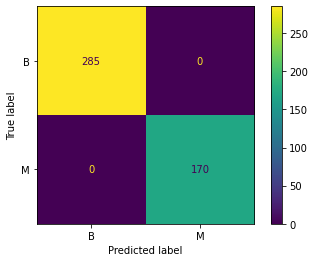

              precision    recall  f1-score   support

           B       1.00      1.00      1.00       285
           M       1.00      1.00      1.00       170

    accuracy                           1.00       455
   macro avg       1.00      1.00      1.00       455
weighted avg       1.00      1.00      1.00       455


Métricas de avaliação de teste:
[[72  0]
 [ 3 39]]


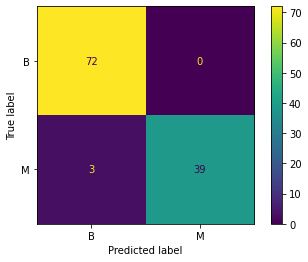

              precision    recall  f1-score   support

           B       0.96      1.00      0.98        72
           M       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



In [ ]:
metricas_classificacao(grid_ab, X_train, X_test, y_train, y_test)

Vamos rodar o modelo completo, só pra ver se o modelo com menos 2 features é melhor

Fitting 5 folds for each of 2 candidates, totalling 10 fits

Métricas de avaliação de treino:
[[285   0]
 [  0 170]]


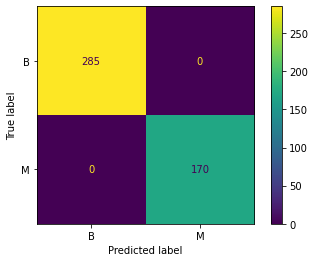

              precision    recall  f1-score   support

           B       1.00      1.00      1.00       285
           M       1.00      1.00      1.00       170

    accuracy                           1.00       455
   macro avg       1.00      1.00      1.00       455
weighted avg       1.00      1.00      1.00       455


Métricas de avaliação de teste:
[[72  0]
 [ 4 38]]


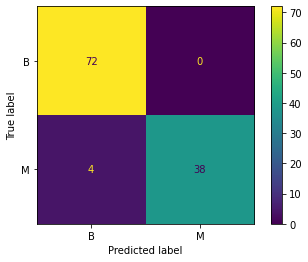

              precision    recall  f1-score   support

           B       0.95      1.00      0.97        72
           M       1.00      0.90      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114



In [ ]:
from sklearn.ensemble import AdaBoostClassifier

pipe = Pipeline([("ab", AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                                                 criterion="gini",
                                                                                 max_features="sqrt",
                                                                                 random_state=42),
                                           random_state=42))])

param_grid_ab = {"ab__n_estimators" : [100, 150]}

splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_ab = GridSearchCV(pipe, param_grid_ab, scoring="f1_weighted", cv=splitter, verbose=10, n_jobs=-1)

grid_ab.fit(X_train, y_train)

metricas_classificacao(grid_ab, X_train, X_test, y_train, y_test)

Vamos mudar o estimador do RFE - usamos a regressão logística com o LASSO!

Ou seja, estamos usando os `.coef_` pra atribuir a importância das features

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([("ss", StandardScaler()),
                 ("rfe", RFE(estimator=LogisticRegression(random_state=42,
                                                          penalty="l1",
                                                          solver="liblinear"))),
                 ("ab", AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                                                 criterion="gini",
                                                                                 max_features="sqrt",
                                                                                 random_state=42),
                                           n_estimators=150,
                                           random_state=42))])

param_grid_ab = {"rfe__estimator__C" : [0.001, 0.01],
                 "rfe__n_features_to_select" : range(1, X_train.shape[1]+1)}

splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_ab = GridSearchCV(pipe, param_grid_ab, scoring="f1_weighted", cv=splitter, verbose=10, n_jobs=-1)

grid_ab.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('ss', StandardScaler()),
                                       ('rfe',
                                        RFE(estimator=LogisticRegression(penalty='l1',
                                                                         random_state=42,
                                                                         solver='liblinear'))),
                                       ('ab',
                                        AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                                                                 max_features='sqrt',
                                                                                                 random_state=42),
                                                           n_estimators=150,
                                                           random_state=4

In [ ]:
grid_ab.best_params_

{'rfe__estimator__C': 0.001, 'rfe__n_features_to_select': 28}


Métricas de avaliação de treino:
[[285   0]
 [  0 170]]


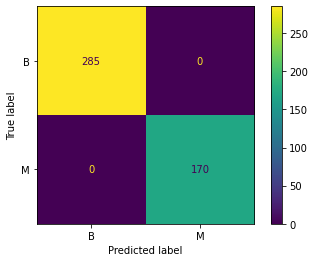

              precision    recall  f1-score   support

           B       1.00      1.00      1.00       285
           M       1.00      1.00      1.00       170

    accuracy                           1.00       455
   macro avg       1.00      1.00      1.00       455
weighted avg       1.00      1.00      1.00       455


Métricas de avaliação de teste:
[[72  0]
 [ 5 37]]


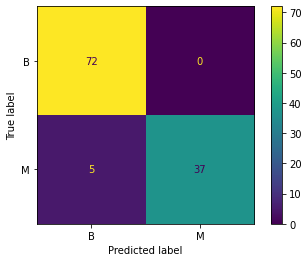

              precision    recall  f1-score   support

           B       0.94      1.00      0.97        72
           M       1.00      0.88      0.94        42

    accuracy                           0.96       114
   macro avg       0.97      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114



In [ ]:
metricas_classificacao(grid_ab, X_train, X_test, y_train, y_test)

_____________

Uma versão mais "enxuta" (tem mais variáveis auxilares pros objetos) do código com o grid search

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

rfe_estimator = LogisticRegression(random_state=42,penalty="l1",solver="liblinear")
rfe_obj = RFE(estimator=rfe_estimator)

ab_base_estimator = DecisionTreeClassifier(max_depth=1, criterion="gini", max_features="sqrt", random_state=42)
ab_obj = AdaBoostClassifier(base_estimator=ab_base_estimator, n_estimators=150, random_state=42)

pipe = Pipeline([("ss", StandardScaler()),
                 ("rfe", rfe_obj),
                 ("ab", ab_obj)])

param_grid_ab = {"rfe__estimator__C" : [0.001, 0.01],
                 "rfe__n_features_to_select" : range(1, X_train.shape[1]+1)}

splitter = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_ab = GridSearchCV(pipe, param_grid_ab, scoring="f1_weighted", cv=splitter, verbose=10, n_jobs=-1)

grid_ab.fit(X_train, y_train)